In [1]:
import os
import math
import pandas as pd
import numpy as np
import random
import dateutil.parser
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates
%matplotlib inline
from pandas.tools.plotting import scatter_matrix
from sklearn import linear_model, preprocessing
#import statsmodels.formula.api as smf
import statsmodels.api as sm
from IPython.display import display
import warnings
import seaborn as sns
import grab_data as grab_data

In [2]:
csv_files = ['./data/'+file for file in os.listdir('./data/') if '.csv' in file]
df_imported = pd.concat([pd.read_csv(file, index_col=0) for file in csv_files])
df_imported.index = pd.DatetimeIndex(df_imported.sort_index().index, freq='H')
grouped = df_imported.groupby(level=0)
df_imported = grouped.last()
df_imported.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 480 entries, 2016-05-17 20:00:00 to 2016-06-06 19:00:00
Freq: H
Data columns (total 25 columns):
$                           480 non-null int64
dateStamp                   80 non-null object
dew_point                   480 non-null float64
modelCode                   80 non-null object
modelRun                    80 non-null float64
periodSchedule              80 non-null float64
pressure                    480 non-null int64
screen_relative_humidity    480 non-null float64
sea_temperature             480 non-null float64
surf_max                    80 non-null float64
surf_min                    80 non-null float64
swell_direction1            80 non-null float64
swell_direction2            80 non-null float64
swell_direction3            80 non-null float64
swell_height1               80 non-null float64
swell_height2               80 non-null float64
swell_height3               80 non-null float64
swell_period1               80 non-

# Helper Functions

In [3]:
default_fig_width = 15
def plot_datetime_series(series, title = '', xlabel='Time', ylabel='Average Wave Height in m', label=['-', '-', '-', '-']):
    if(type(series) is not list):
        series = [series]
    if(type(label) is not list):
        label = [label]
    for i, s in enumerate(series):
        s = s.copy()
        s.sort_index(inplace=True)
        if type(s.index) is not pd.tseries.index.DatetimeIndex:
            dates = matplotlib.dates.date2num([dateutil.parser.parse(dt) for dt in s.index])
        else:
            dates = s.index
        plt.plot_date(
            dates,
            s.values,
            label[i]
        )
    if title:
        plt.title(title)
    if ylabel != '':
        plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.gcf().autofmt_xdate()
    if len(series) > 1:
        plt.legend([s.name for s in series], loc=2)
    plt.show()

def plot_scatter_correlation(df, target):
    ncols = 3
    nrows = math.ceil(len(df.columns)/ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(default_fig_width,4*nrows))
    #plt.tight_layout()
    for i,variable in enumerate(df.columns):
        row = math.floor(i / nrows)
        col = i % 3
        if nrows > 1:
            axis = axes[row,col]
        else:
            axis = axes[col]
        correlation = df[variable].corr(target)
        title = "corr = {:.5f}".format(correlation)    #variable + ': ' + "{:.5f}".format(correlation)      
        sns.regplot(df[variable], target, ax=axis)#, 'o')
        axis.set_title(title)
        #df.plot.scatter(x=variable, y=target_var, marker='+', ax=axes[row,col], title=title)
    unused_axes = ncols * nrows - len(df.columns) 
    for i in range(1, unused_axes+1):
        if nrows > 1:
            axis = axes[-1,-i]
        else:
            axis = axes[-i]
        fig.delaxes(axis)

def normalize(df_in):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return df_in.apply(preprocessing.scale)

available target values: 80


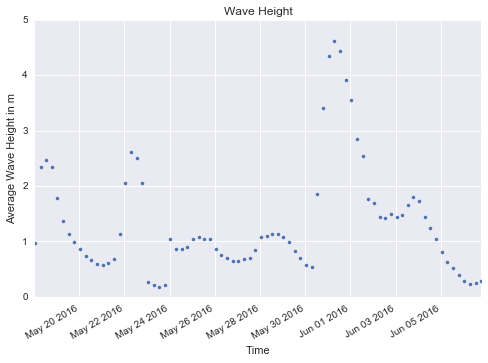

target values after interpolation: 475


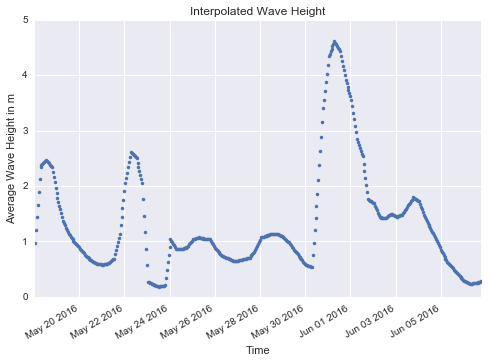

In [4]:
target_var = 'surf_avg'
s_target = pd.Series( ((df_imported['surf_max'] + df_imported['surf_min']) / 2)*0.3048, name=target_var )
print('available target values:', s_target.count())
plot_datetime_series(s_target, 'Wave Height', 'Time', 'Average Wave Height in m', '.')
# fill NAs with linearly interpolated data where explanatory data is present
s_target = s_target.loc[df_imported['wind_speed'].notnull()].interpolate()
#---respective data removed---- there's a big gap which we shouldn't interpolate
#s_target['2016-05-16 14:00:00':'2016-05-18 00:00:00'] = None
#-- uncomment to remove some outliers
#s_target = s_target[:'May 24 2016, 1am']
print('target values after interpolation:', s_target.count())  
plot_datetime_series(s_target, 'Interpolated Wave Height', 'Time', 'Average Wave Height in m', '.')

# Drop Irrelevant Variables
Because these variables have no predictive power from logical and visual judgement, they are discarded at this point.

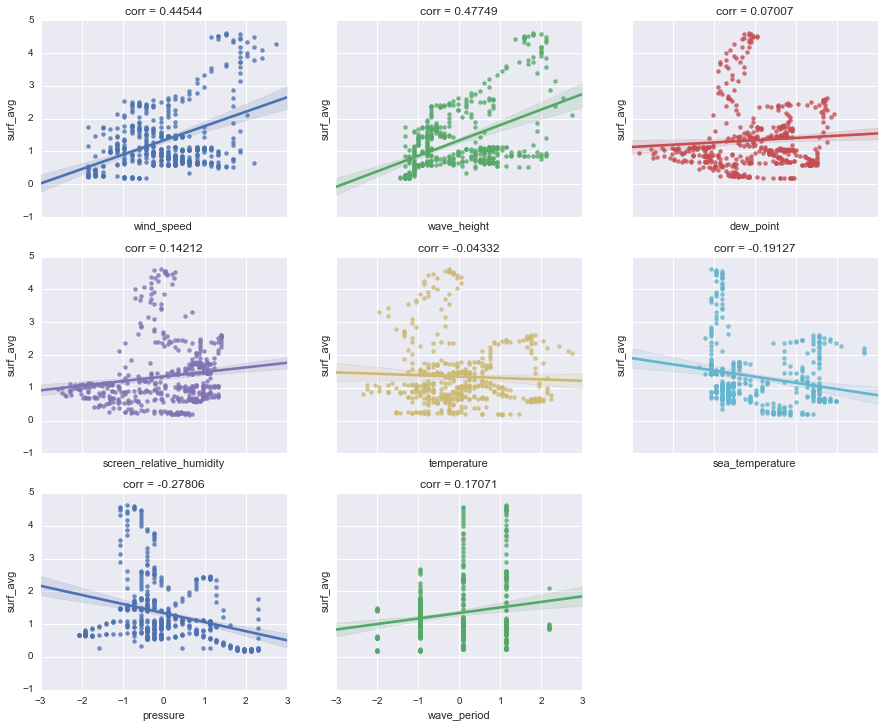

In [5]:
# sorted out at this point: 'dew_point', 'screen_relative_humidity', 'temperature', 'sea_temperature', 'pressure', 'wave_period'
plot_scatter_correlation(
    normalize(df_imported[['wind_speed', 'wave_height', 'dew_point', 'screen_relative_humidity', 'temperature', 'sea_temperature', 'pressure', 'wave_period']].dropna()),
    s_target
)
    
def drop_unused_variables(df_in):
    return df_in[['wind_direction','wind_speed', 'wave_height']]#, 'dew_point', 'screen_relative_humidity', 'temperature', 'sea_temperature', 'pressure', 'wave_period']]

df_explanatory = drop_unused_variables(df_imported)

# Transforming Wind Direction
## Sine and Cosine Approach

In [6]:
def degrees_to_sin_cos(df_in, columns):
    if(type(columns) is not list):
        columns = [columns]
    df_radians = df_in[columns].apply(lambda deg: deg * (math.pi / 180))
    #print(df_radians.columns)
    #def sine(series):
    #    pd.Series(series.apply(math.sin)
    df_sin = df_radians.apply(lambda series: series.map(math.sin))
    df_cos = df_radians.apply(lambda series: series.map(math.cos))
    df_sin.columns = [col + '-Sin' for col in df_sin.columns]
    df_cos.columns = [col + '-Cos' for col in df_cos.columns]
    return pd.concat(
        [
            df_in.drop(columns, axis=1),
            df_sin,
            df_cos
            #directional.angle.radian_matrix_to_sin_cos_matrix(df_radians[columns])
        ], 
        axis=1)

circular_example = pd.DataFrame({'degrees':[359.9, 359.9, 0.1, 0.1], 'other_data':[1,2,3,4]})
#display(circular_example)
#radians_example = pd.DataFrame({'radians': [deg * (math.pi / 180) for deg in circular_example['degrees']]})
#display(radians_example)
#display(directional.angle.radian_matrix_to_sin_cos_matrix(radians_example))

display(circular_example)
display(degrees_to_sin_cos(circular_example, 'degrees'))

,degrees,other_data
0,359.9,1
1,359.9,2
2,0.1,3
3,0.1,4


,other_data,degrees-Sin,degrees-Cos
0,1,-0.001745,0.999998
1,2,-0.001745,0.999998
2,3,0.001745,0.999998
3,4,0.001745,0.999998


,wind_direction
2016-05-17 20:00:00,NE
2016-05-17 21:00:00,NE
2016-05-17 22:00:00,ENE
2016-05-17 23:00:00,NE
2016-05-18 00:00:00,NE


becomes


,wind_direction
2016-05-17 20:00:00,45.0
2016-05-17 21:00:00,45.0
2016-05-17 22:00:00,67.5
2016-05-17 23:00:00,45.0
2016-05-18 00:00:00,45.0


becomes


,wind_direction-Sin,wind_direction-Cos
2016-05-17 20:00:00,0.707107,0.707107
2016-05-17 21:00:00,0.707107,0.707107
2016-05-17 22:00:00,0.923880,0.382683
2016-05-17 23:00:00,0.707107,0.707107
2016-05-18 00:00:00,0.707107,0.707107


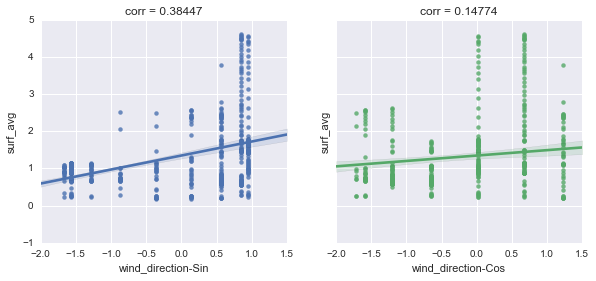

In [7]:
df_explanatory = df_explanatory.dropna()
compass_directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
def transform_wind_direction_sin_cos(df_in):
    df_out = df_in.copy()
    df_out['wind_direction'] = df_out['wind_direction'].apply(lambda dir: (360 / len(compass_directions)) * compass_directions.index(dir))
    df_out = degrees_to_sin_cos(df_out, 'wind_direction')
    return df_out
display(df_explanatory[['wind_direction']].head())
print('becomes')
display(pd.DataFrame(df_explanatory['wind_direction'].apply(lambda dir: (360 / len(compass_directions)) * compass_directions.index(dir))).head())
print('becomes')
df_wind_direction_sin_cos = transform_wind_direction_sin_cos(df_explanatory)
display(df_wind_direction_sin_cos[['wind_direction-Sin','wind_direction-Cos']].head())
plot_scatter_correlation(
    normalize(df_wind_direction_sin_cos[['wind_direction-Sin','wind_direction-Cos']]), 
    s_target
)

## Degree Difference Approach
The previous approach gives a numerical view on wind direction where 360 and 0 degrees are equal. However, this doesn't result in a linear correlation, which is expected to exist for wind direction.

Highest correlation is 0.445 at 68 degrees. This is of course the same as at 248 degrees.


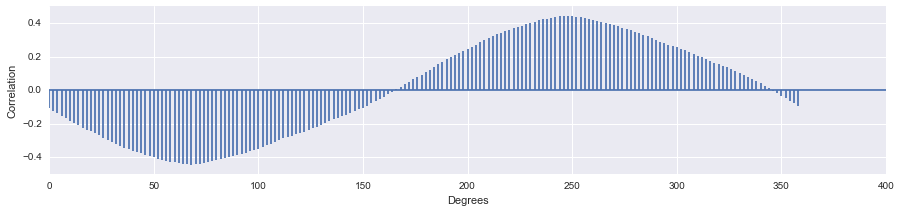

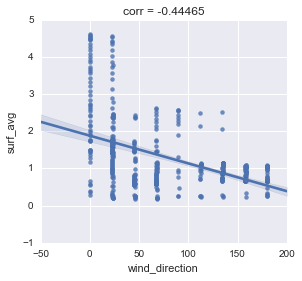

In [8]:
def compass_to_degrees(s_in):
    return s_in.apply(lambda dir: (360 / len(compass_directions)) * compass_directions.index(dir))
#degrees_base = compass_to_degrees(df_explanatory['wind_direction'])
degree_corr = pd.Series(index=range(0,360,2))
def compute_degree_diff(s_in, i):
    degrees_base = compass_to_degrees(s_in)
    diff = abs(degrees_base - i) % 360
    def under_180(alpha):
        if(alpha > 180):
            return 360 - alpha
        else:
            return alpha
    return diff.apply(under_180)
for i in degree_corr.index:
    degree_corr[i] = compute_degree_diff(df_explanatory['wind_direction'], i).corr(s_target)
    
fig, ax = plt.subplots(figsize=(math.floor(default_fig_width),3))
ax.vlines(
    x=degree_corr.index, 
    ymin=0,
    ymax=degree_corr.values,
    color=sns.color_palette()[0]
)
ax.axhline(color=sns.color_palette()[0])
ax.set_xlabel('Degrees')
ax.set_ylabel('Correlation')
max_corr = degree_corr.max()
max_corr_at = degree_corr[abs(degree_corr) == max_corr].index[0]
print('Highest correlation is {:.3f}'.format(max_corr) ,'at', max_corr_at, 'degrees. This is of course the same as at', max_corr_at+180, 'degrees.')
df_transformed = df_explanatory.copy()
def transform_wind_direction(df_in):
    df_out = df_in.copy()
    df_out['wind_direction'] = compute_degree_diff(df_out['wind_direction'], max_corr_at)
    return df_out
df_transformed = transform_wind_direction(df_explanatory)
plot_scatter_correlation(df_transformed[['wind_direction']], s_target)
#ax.set_xticklabels(degree_corr.index[::2])

In [9]:
print('Data types of columns')
pd.DataFrame({'column':df_transformed.columns},[str(df_transformed[column].dtype) for column in df_transformed.columns])

Data types of columns


,column
float64,wind_direction
int64,wind_speed
float64,wave_height


In [10]:
df_train = pd.merge(df_transformed, pd.DataFrame(s_target), left_index=True, right_index=True).dropna()
df_train.count()

wind_direction    475
wind_speed        475
wave_height       475
surf_avg          475
dtype: int64

# Normalization

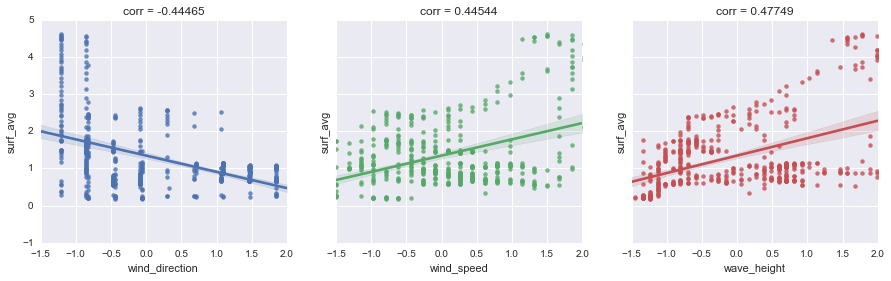

In [11]:
#mean_target = s_target.mean()
#std_target = s_target.std()
#def denormalize_target(series):
#    return series * std_target + mean_target
df_train[df_explanatory.columns] = normalize(df_train[df_explanatory.columns])
plot_scatter_correlation(df_train[df_explanatory.columns], df_train[target_var])
#df_train = df_train.apply(preprocessing.scale)

# Determining the Lag
In order to find out the lag between target variable and each of the explanatory variables, a cross correlation for all lags between 0 and 40 is computed. Afterwards, the correlation of the best fitting lags is looked at more closely.

In [12]:
def cross_correlation(s1, s2, minlag=0, maxlag=72):
    if((s1.index != s2.index).any()):
        print('Indexes differ!')
        return
    s_result = pd.Series(index=range(minlag, maxlag))
    for lag in range(minlag, maxlag+1):
        s_result[lag] = s1.shift(lag).corr(s2)
    return s_result

def abs_max_at(s):
    max_index = s.index[0]
    max_value = s.values[0]
    for i, v in s.iteritems():
        if abs(v) > abs(max_value):
            max_index = i
            max_value = v
    return max_index

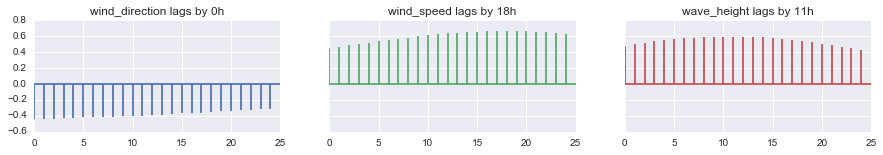

In [13]:
optimal_lags = pd.Series(index=df_explanatory.columns)
nrows = math.ceil(len(df_explanatory.columns) / 3)
fig, axes = plt.subplots(nrows=nrows, ncols=3, sharey=True, sharex=True, figsize=(default_fig_width,nrows*2))
#plt.tight_layout()
for i,var in enumerate(df_explanatory.columns):
    row = math.floor(i / 3)
    col = i % 3
    if nrows == 1: axis = axes[col]
    else: axis = axes[row,col]
    if i < len(sns.color_palette()): color = sns.color_palette()[i]
    else: color = sns.color_palette()[i-len(sns.color_palette())]     
    xcorr = cross_correlation(df_train[var], df_train[target_var], maxlag=24)
    optimal_lags[var] = abs_max_at(xcorr)
    axis.vlines(x=xcorr.index, ymin=0, ymax=xcorr.values, color=color)
    axis.axhline(color=color)
    axis.set_title(var + ' lags by ' + "{0:g}".format(optimal_lags[var]) + 'h')
#fig.delaxes(axes[1,2])
#fig.delaxes(axes[1,1])
#fig.delaxes(axes[1,0])

The highest correlation seems to be at a lag of about -5 to -15, but is different for each variable. 
- Wind speed appears to have a very high lag, just like the wind direction.
- Wave height and wave period both have a smaller lag.

complete training rows left after lagging: 457 (lost: 18 )


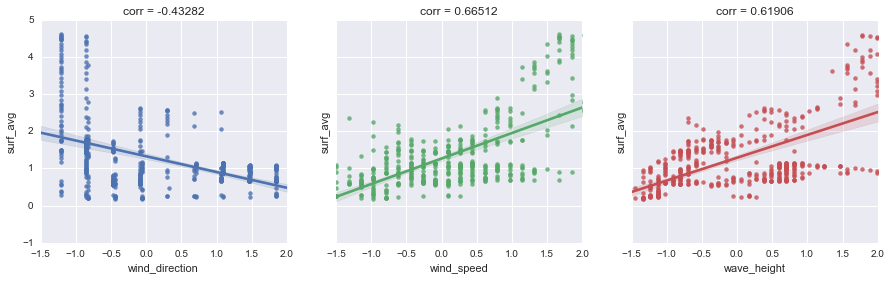

In [14]:
def lag(df_in):
    df_lagged = pd.DataFrame()
    for var, lag in optimal_lags.iteritems():
        df_lagged = pd.concat(
            [df_lagged, df_in[var].shift(lag, freq='H', axis=0)],
            axis=1
        )
    return df_lagged
df_lagged = pd.concat([
        lag(df_train[df_explanatory.columns]),
        df_train[target_var]], 
        axis=1
).dropna()
print('complete training rows left after lagging:', len(df_lagged), '(lost:', len(df_train)-len(df_lagged), ')')

plot_scatter_correlation(df_lagged[df_explanatory.columns], df_lagged[target_var])

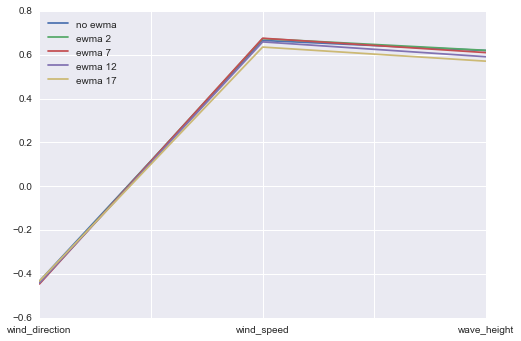

In [15]:
corr_with_target = pd.DataFrame(
    {'no ewma': [df_lagged[column].corr(df_lagged[target_var]) for column in df_explanatory.columns]},
    index = df_explanatory.columns
)
#df_ewma3 = pd.ewma(df_explanatory, span=3)
for span in range(2,20, 5):
    corr_with_target['ewma '+str(span)] = pd.Series([ pd.ewma(df_lagged[column], span=span).corr(df_lagged[target_var]) for column in df_explanatory.columns], index=df_explanatory.columns)
corr_with_target.plot()
#column = 'pressure'
#pd.ewma(df_train[column], span=3).corr(df_train[target_var])

In [16]:
def preprocess(df_in):
    df_out = df_in.copy()
    preprocessing_functions = [
        'drop_unused_variables',
        'transform_wind_direction',
        'normalize',
        'lag'
    ]
    for fn in preprocessing_functions:
        df_out = globals()[fn](df_out)
    return df_out.dropna()

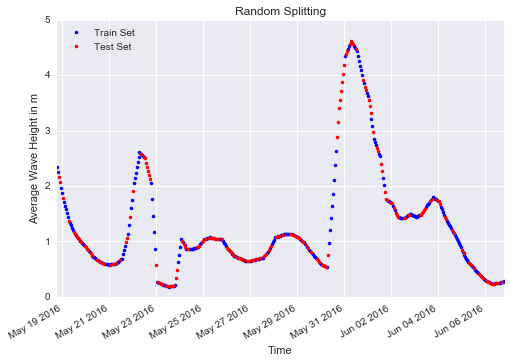

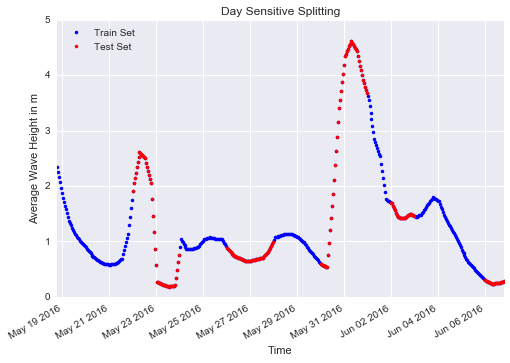

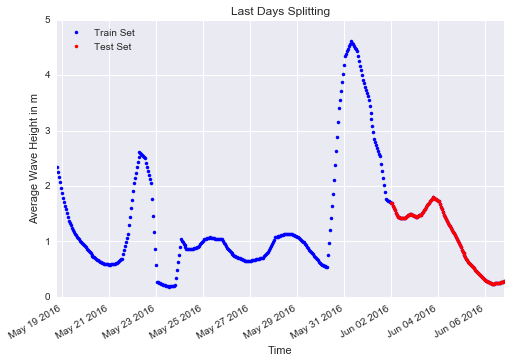

In [17]:
# randomly sample a train and test set
def split_dataset(df_in, percent_test):
    total_size = len(df_in)
    test_set_size = math.floor(percent_test * total_size)
    df_train = df_in.copy()
    record_labels = [ df_train.index[randint] for randint in random.sample(range(total_size), test_set_size) ]
    df_test = pd.DataFrame(df_train.loc[record_labels])
    df_train = df_train.drop(record_labels)
    return df_train, df_test

def split_dataset_day_sensitive(df_in, percent_test):
    days = pd.Series(df_in.index).map(pd.Timestamp.date).unique()
    total_size = len(days)
    test_set_size = math.floor(percent_test * total_size)
    df_train = df_in.copy()
    record_labels = [ str(days[randint]) for randint in random.sample(range(total_size), test_set_size) ]
    df_test = pd.concat([df_train[l] for l in record_labels], axis=0)
    for l in record_labels:
        df_train.drop(df_train[l].index)
    return df_train, df_test

def split_dataset_last_days(df_in, days_count):
    days = pd.Series(df_in.index).map(pd.Timestamp.date).unique()
    record_labels = [ str(days[i]) for i in range(-days_count-1, 0) ]
    df_train = df_in.copy()
    df_test = pd.concat([df_train[l] for l in record_labels], axis=0)
    for l in record_labels:
        df_train.drop(df_train[l].index)
    return df_train, df_test

train_set, test_set = split_dataset(df_lagged, 0.4)
train_set[target_var].name = 'Train Set'
test_set[target_var].name = 'Test Set'
plot_datetime_series([train_set[target_var], test_set[target_var]], label=['b.', 'r.'], title='Random Splitting')

train_set, test_set = split_dataset_day_sensitive(df_lagged, 0.4)
train_set[target_var].name = 'Train Set'
test_set[target_var].name = 'Test Set'
plot_datetime_series([train_set[target_var], test_set[target_var]], label=['b.', 'r.'], title='Day Sensitive Splitting')

train_set, test_set = split_dataset_last_days(df_lagged, 4)
train_set[target_var].name = 'Train Set'
test_set[target_var].name = 'Test Set'
plot_datetime_series([train_set[target_var], test_set[target_var]], label=['b.', 'r.'], title='Last Days Splitting')


coefficients:  [-0.82470218 -0.16359161  1.0909082 ]


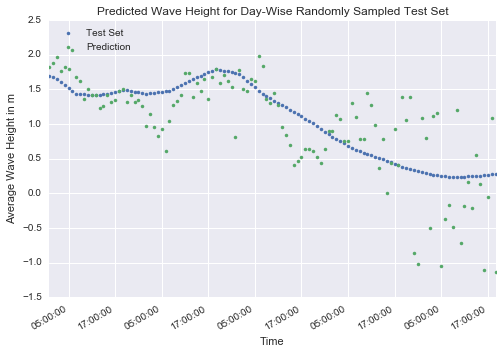

In [18]:
# perform prediction data assuming 0 lag
regr = linear_model.LinearRegression()
train_set, train_set = split_dataset_day_sensitive(df_train, 0.4)
regr.fit(train_set[df_explanatory.columns].as_matrix(), train_set[target_var].as_matrix())
coefficients = regr.coef_
print('coefficients: ', coefficients)

predictions = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set.index, name='Prediction')
plot_datetime_series([
        test_set[target_var], 
        predictions
    ], 'Predicted Wave Height for Day-Wise Randomly Sampled Test Set', 'Time', 'Average Wave Height in m', ['.', '.'])

coefficients:  [-0.51846206  0.23007924  0.53414222]
intercept:  1.28770990619


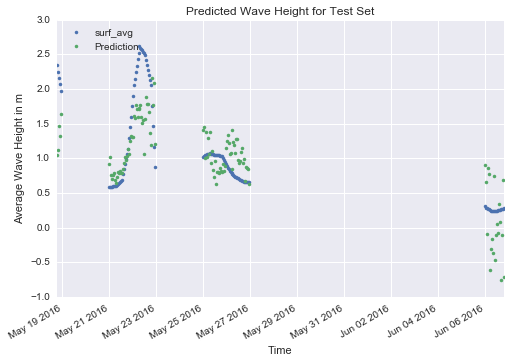

In [19]:
regr = linear_model.LinearRegression()
train_set, test_set = split_dataset_day_sensitive(df_lagged.dropna(), 0.3)
regr.fit(train_set[df_explanatory.columns].as_matrix(), train_set[target_var].as_matrix())
coefficients = regr.coef_
intercept = regr.intercept_
print('coefficients: ', coefficients)
print('intercept: ', intercept)
predictions = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set.index, name='Prediction')
plot_datetime_series([test_set[target_var], predictions], 'Predicted Wave Height for Test Set', 'Time', 'Average Wave Height in m', ['.','.'])

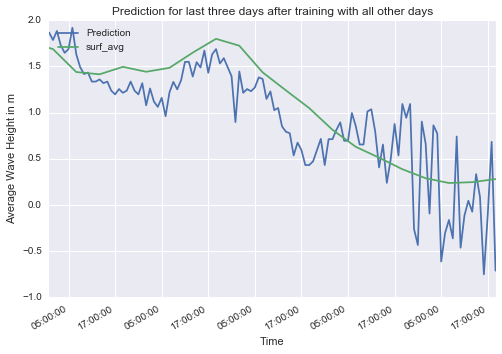

In [20]:
def train_linear_model(train_set, target=None):
    train_set = train_set.copy()
    if target is None:
        target = train_set[target_var]
        train_set = train_set.drop(target_var, axis=1)
    model = linear_model.LinearRegression()
    model.fit(
        train_set.as_matrix(), 
        target.as_matrix()
    )
    return model
def predict(test_set, model):
    test_set = test_set.copy()
    if target_var in test_set.columns:
        test_set = test_set.drop(target_var, axis=1)
    return pd.Series(
        model.predict(test_set.as_matrix()), 
        name='Prediction', 
        index=test_set.index
    )

train_set, test_set = split_dataset_last_days(df_lagged, 4)
model = train_linear_model(train_set)
#train_set
plot_datetime_series(
    [
        predict(test_set, model),
        test_set[target_var],
    ],
    title= 'Prediction for last three days after training with all other days'
)

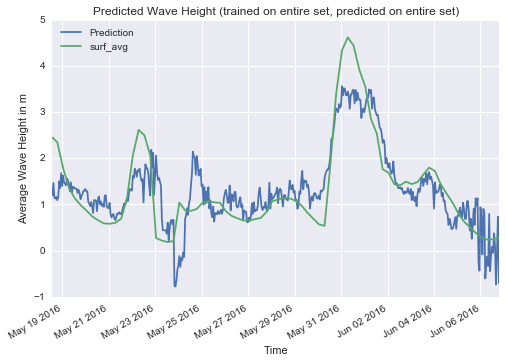

In [21]:
final_explanatory = preprocess(df_imported).join(s_target).dropna()[df_explanatory.columns]
final_target = final_explanatory.join(s_target)[target_var]
fully_trained_regression = linear_model.LinearRegression()
fully_trained_regression.fit(
    final_explanatory.as_matrix(), 
    final_target.as_matrix()
)
def make_prediction(df_in):
    return pd.Series(fully_trained_regression.predict(df_in.as_matrix()), name='Prediction', index=df_in.index)
plot_datetime_series([make_prediction(final_explanatory), final_target], 'Predicted Wave Height (trained on entire set, predicted on entire set)')

In [22]:
df_lagged.head()
lm = sm.OLS(df_lagged[target_var], df_lagged[df_explanatory.columns]).fit()
#lm = sm.OLS(final_target, final_explanatory).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               surf_avg   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     60.09
Date:                Mon, 06 Jun 2016   Prob (F-statistic):           9.88e-33
Time:                        23:30:32   Log-Likelihood:                -798.14
No. Observations:                 457   AIC:                             1602.
Df Residuals:                     454   BIC:                             1615.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
wind_direction    -0.4632      0.069     -6.749      0.000        -0.598    -0.328
wind_speed         0.3993      0.120      3.336      0.001         0.164     0.635
wave_height        0.4492      0.117      3.827      0.000         0.219     0.680
==============================================================================
Omnibus:                        5.907   Durbin-Watson:                   0.038
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                5.715
Skew:                           0.264   Prob(JB):                       0.0574
Kurtosis:                       3.148   Cond. No.                         3.28
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R² value indicates the percentage of variance in the data which are explained by the model. This is a good fit, but also may indicate overfit.

In [23]:
print('p value >= 0.05')
print(lm.pvalues.loc[[v >= 0.05 for v in lm.pvalues]])
print()
print('p value < 0.05')
print(lm.pvalues.loc[[v < 0.05 for v in lm.pvalues]])

p value >= 0.05
Series([], dtype: float64)

p value < 0.05
wind_direction    4.543654e-11
wind_speed        9.194562e-04
wave_height       1.477352e-04
dtype: float64


P value greater than 0.05 means that it is likely that the feature has no importance for prediction. The coefficients 95% confidence interval includes zero.

H0 = There is no relationship between feature and target.

P value > 0.05 means we fail to reject the null hypothesis.

# Make a Real Prediction

In [24]:
if 'live_target' not in vars():
    live_target = grab_data.target(5)
    live_target.name= 'Surfline Prediction'
if 'live_explanatory' not in vars():
    live_explanatory = grab_data.explanatory()

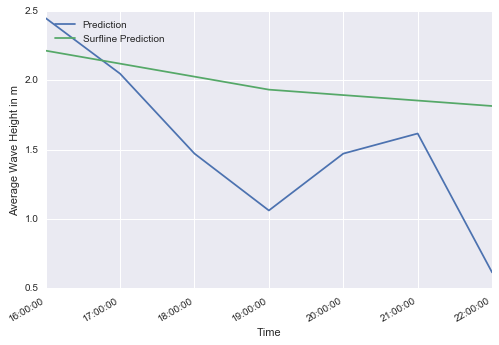

2016-06-06 01:00:00    2.057400
2016-06-06 02:00:00    2.150364
2016-06-06 03:00:00    2.243328
2016-06-06 04:00:00    2.336292
2016-06-06 05:00:00    2.429256
2016-06-06 06:00:00    2.522220
2016-06-06 07:00:00    2.615184
2016-06-06 08:00:00    2.595372
2016-06-06 09:00:00    2.575560
2016-06-06 10:00:00    2.555748
2016-06-06 11:00:00    2.535936
2016-06-06 12:00:00    2.516124
2016-06-06 13:00:00    2.496312
2016-06-06 14:00:00    2.402586
2016-06-06 15:00:00    2.308860
2016-06-06 16:00:00    2.215134
2016-06-06 17:00:00    2.121408
2016-06-06 18:00:00    2.027682
2016-06-06 19:00:00    1.933956
2016-06-06 20:00:00    1.894586
2016-06-06 21:00:00    1.855216
2016-06-06 22:00:00    1.815846
2016-06-06 23:00:00    1.776476
2016-06-07 00:00:00    1.737106
2016-06-07 01:00:00    1.697736
2016-06-07 02:00:00    1.649476
2016-06-07 03:00:00    1.601216
2016-06-07 04:00:00    1.552956
2016-06-07 05:00:00    1.504696
2016-06-07 06:00:00    1.456436
                         ...   
2016-06-

In [25]:
preprocessed = preprocess(live_explanatory)
predictions = make_prediction(preprocessed)
plot_datetime_series([predictions, live_target[predictions.index]])
live_target